---
# Jupyter-Notebook-Tutorial:   

#    Anpassung von Modellen an Messdaten mit der Maximum-Likelihood-Methode

                                                    Günter Quast, Juni 2021
***
## Zusammenfassung

Dieses Tutorial führt in die Grundlage der Anwendung der Maximum-Likelihood-Methode
zur Anpassung an Messdaten ein. Für viele in der Praxis häufig auftretende Probemstellungen
ist die in vielen Anwendungen und Programmpaketen implementierte Methode der "kleinsten
Fehlerquadrate" ("least squares", LSQ) nicht adäquat. Dann die auf soliden mathematiscen
Grundlagen beruhende Maximum-Likelihood-Methode ("Maximum Likelihood Estimation", MSE)
zur Schätung der Modellparameter und ihrer Vertrauensbereiche angewandt werden. 

Dieses Tutorial in Form eines Jupyter-Notebooks bietet neben kurzen Erläuterungen der 
mathematischen Grundlagen insbesondere viele Code-Beispiele in der Sprache *Python*, 
die die Maximum-Likelihood-Methode an typischen Beispielen erläutern und zur Anwendung
in eigenen Anpassungsproblemen angepasst werden können.

Der Beispielcode nutzt das *Python*-Paket [iminuit](https://iminuit.readthedocs.io/en/stable/)
zur numerischen Optimierung und Analyse der Unsicherheiten sowie die im wissenschaftlichen
Rechnen mit *Python* weit verbreiteten Bibliotheken *numpy*, *scipi* und *matplotlib*.
Als anwendungsorientierte Zwischenebene wird das Paket 
[PhyPraKit.phyFit](https://phyprakit.readthedocs.io/en/latest/) verwendet.



## Inhaltsübersicht:

1. Anpassung von Modellen an Messdaten

2. Mathematische Grundlagen der Parameterschätzung

   2.1 Bestimmung der Parameterunsicherheiten und Intervallschätzung
    
     - Parameterschätzug mit dem Maximum-Likelihood Verfahren

     - Bestimmung der Parameterunsicherheiten und Intervallschätzung

     - Alternative Methode zur Bestimmung der Parameterunsicherheiten: Profil-Likelihood

     - log-Likelihood Anpassung einer Exponentialfuntion

3. Anpassung von Verteilungsdichten an Histogramme

   3.1 Beispiel 

4. Maximum-Likelihood und Methode der kleinsten Fehlerquadrate

   4.1 Konstruktion der Kovarianzmatrix

   4.2 Beispiel zur Anpassung an x/y-Daten mit komplexen Unsicherheiten  

5. Beurteilung der Qualität von Anpassungsverfahren

   5.1 Überprüfung mittels Monte-Carlo - Methode ("toy-MC")

---
## Grundsätzliches zu Jupyter Notebooks

Diese Datei vom Typ `.ipynb` enthält ein Tutorial als `Jupyter notebook`.
*Jupyter* bietet eine Browser-Schnittstelle mit einer (einfachen) Entwicklungsumgebung
für *Python*-Code und erklärende Texte im intuitiven *Markdown*-Format.
Die Eingabe von Formeln im *LaTeX*-Format wird ebenfalls unterstützt.

Eine Zusammenstellung der wichtigsten Befehle zur Verwendung von *Jupyter* als Arbeitsumgebung
findet sich im Notebook
[*JupyterCheatsheet.ipynb*](https://git.scc.kit.edu/yh5078/datenanalyse/-/blob/master/jupyter/JupyterCheatsheet.ipynb).
Grundlagen zur statistischen Datenauswertung finden sich in den Notebooks 
[*IntroStatistik.ipynb*](https://git.scc.kit.edu/yh5078/datenanalyse/-/blob/master/jupyter/IntroStatistik.ipynb)
und
[*Fehlerrechnung.ipynb*](https://git.scc.kit.edu/yh5078/datenanalyse/-/blob/master/jupyter/Fehlerrechnung.ipynb).

In *Jupyter* werden Code und Text in jeweils einzelne Zellen eingegeben. 
Aktive Zellen werden durch einen blauen Balken am Rand angezeigt.
Zellen können sich in zwei Zuständen befinden: im Edit-Mode ist das Eingabefeld weiß, 
im Command-Mode ist es ausgegraut.
Durch Klicken in den Randbereich wird der Command-Mode gewählt, ein Klick in das Textfeld einer
Code-Zelle schaltet in den Edit-Mode.
Die Taste `esc` kann ebenfalls verwendet werden, um den Edit-Mode zu verlassen.

Die Eingabe von `a` im Command-Mode erzeugt eine neue leere Zelle oberhalb der aktiven Zelle, 
`b` eine unterhalb. Eingabe von `dd` löscht die betreffende Zelle.

Zellen können entweder den Typ `Markdown` oder `Code` haben.
Die Eingabe von `m` im Command-Mode setzt den Typ Markdown, Eingabe von `y` wählt den Typ Code.

Prozessiert - also Text gesetzt oder Code ausgeführt - wird der Zelleninhalt durch Eingabe von
`shift+return`, oder auch `alt+return` wenn zusätzlich eine neue, leere Zelle erzeugt werden soll.

Die hier genannten Einstellungen sowie das Einfügen, Löschen oder Ausführen von Zellen sind
auch über das PullDown-Menü am oberen Rand verfügbar.

---

## 1. Likelihood-Anpassung von Modellen an Messdaten
***
Die Physik als "Theorie-geleitete Erfahrungswissenschaft" lebt vom
Zusammenspiel theoretischer Hypothesenbildung und deren stringenter
Überprüfung im Experiment. Bei der Interpretation von Messdaten kommt
es daher zunächst darauf an, ob sie überhaupt einem erwarteten Modell 
entsprechen. Erst, wenn diese Frage mit "ja" beantwortet werden kann, 
ist die Extraktion vom Modellparametern sinnvoll.

Leider tragen die meisten der häufig verwendeten Werkzeuge in der 
Voreinstellung dieser Anforderung nicht Rechnung, sondern zielen 
auf eine möglichst genaue Parametrisierung der Daten ab. 
Bei Vorgabe von unpassenden Modellen werden dazu die Parameterfehler
so weit vergrößert, dass die Parametrisierung möglichst genau passt.

Um den besonderen Bedingungen der Datenauswertung in der Physik
gerecht zu werden, ist die Verwendung von eigenem Programmcode, 
idealerweise in der Programmiersprache *Python* in einem 
Jupyter-Notebook, häufig notwendig, da die meisten mittels einer
grafischen Oberfläche zu bedienenden Werkzeuge zur statistischen
Datenauswertung den Anforderungen nicht oder nur zum Teil genügen. 

Wichtige Anforderugnen an eine Methode zur Modellanpassung sind:

- Alle Messunsicherheiten sollten direkt bei der Modellanpassung berücksichtigt
  und entsprechend modelliert werden, um sie vollständig und korrekt auf die
  Unsicherheiten der Parameter zu propagieren. Eine später von Hand
  durchgeführte Fehlerfortpflanzung ist aufwändig und funktioniert nur
  in einfachsten Fällen.   

- Häufig treten auch relative Unsicherheiten als Bruchteil des wahren 
  Messwerts auf, z.$\,$B. bei Kalibrationsunsicherheiten o.\,Ä..
  Wenn solche relative Unsicherheiten korrekt behandelt werden müssen, 
  gelingt das mit der in vielen Anpassungsprogrammen implementierten
  Methode der kleinsten Fehlerquadrate nur noch eingeschränkt. 
  Bessere Parameterschätzungen nutzen die Maximum-Likelihood-Methode 
  ("MLE", Maximum Likelihood Estimation) mit an das Prolem angepassten
  Likelihood-Funktionen. 

- In der Quanten-, Kern- und Teilchenphysik treten als Messgrößen
  Zählraten in Abhängigkeit von Energie, Streuwinkel oder anderen
  Größen auf, die üblicherweise als Häufigkeitsverteilung (Histogramm)
  dargestellt werden. Die Einträge in einem Intervall eines Histogramms
  (einem sog. `Bin`) sind aber nicht Gauß-, sondern Poisson-verteilt. 
  Auch näherungsweise können Bins mit Null Einträgen mit einer - oft immer
  noch verwendeten - angepassten Methode der kleinsten Fehlerquadrate
  nicht berücksichtigt werden. Zur Anpassung von Modellen an Histogramme
  müssen also ebenfalls maximum-likelihood Methoden angewendet werden.
  
- Bei der Analyse von sehr kleinen Zählraten bei nur selten eintretenden
  Ereignissen kann schon die Notwendigkeit zur Aufteilung in Bins zur einem
  Informationsverlust und zu einer Verzerrung des Ergebnisses führen.
  In solchen Fällen sollte ein ungebinnter Maximum-Likelihod-Fit zur
  Anwendung kommen.

- Bei der Anpassung an zweidimensonale Datenppunkte $(x_i, y_i)$ sollten 
  die verwendeten Werkzeuge Unsicherheiten in Abszissenrichtung (entlang
  der "x-Achse") zusätzlich zu denen in Ordinatenrichtung behandeln können. 
  Die Unterstützung von korrelierten Unsicherheiten ist ebenfalls notwendig, u
  m typische Charakteristika von Messgeräten, wie korrelierte 
  Kalibrationsunsicherheiten zusätzlich zu den unabhängigen 
  Digitalisierungsunsicherheiten und Rauschbeiträgen, darstellen zu können.

Leider gibt es kaum Anpassungswerkzeuge, die alle genannten Anforderungen
gleichzeitig erfüllen. Deshalb wurde am ETP in zahlreichen Bachelor-Arbeiten
ein quelloffenes Anpassungswerkzeug, [kafe2](https://github.com/dsavoiu/kafe2)
entwickelt, das die genannten Aspekte abdeckt. Allerdings ist der Programmcode
wegen der großen Zahl an Optionen und Methoden sehr komplex und für Einsteiger
unübersichtlich.

Zur Illustration der Vorgehensweise wird daher in diesem Tutorial ein
einziges, sehr flexibles Werkzeug zur numerischen Optimierung und 
Analyse der Parameterunsicherheiten verwendet, nämlich das am CERN 
entwickelte Paket `Minuit` bzw. dessen Python-Interface 
[iminuit](https://iminuit.readthedocs.io/en/stable/). 
Eine schlanke Implementierung von Anwendungsbeispielen bietet das Paket 
[PhyPraKit.phyFit](https://phyprakit.readthedocs.io/en/latest/), das 
hier verwendet wird, um die Grundlagen der Anpassung von Modellen an 
Messdaten mit der Maximum-Likelihood Methode darzustellen.  

***

## 2. Mathematische Grundlagen der Parameterschätzung
***

In diesem Tutorial werden ausgehend vom Maximum-Likelihood-Prinzip 
zunächst typische Anwendung zur Anpassung von Verteilungsdichten an
Messdaten diskutiert und dann die Verbindung zur altbekannten Methode
der kleinsten Quadrate zur Anpassung von parameterbehafteten 
Modellfunktionen $y_i = f(x_i; *par )$ an zweidimensionale Datenpunkte
$(x_i, y_i)$ dargestellt. 

Ausgangspunkt der Überlegungen ist der auf der Maximum-Likeliood Methode
basierende Formalismus zur Parameterschätzung von Verteilungsdichten, 
die den Messergebnissen zu Grunde liegen. Manchmal sind die Parameter der 
Verteilungsdichte selbst interessant, z.$\,$B. bei der Lebensdauerverteilung 
von quantenmechanischen Zuständen oder von (Elementar-)Teilchen.
Häufig treten Parameter von Verteilungsdichten aber auch nur als 
"Störparameter" auf, die statistische Fluktuationen um einen angenommenen
wahren Wert beschreiben. Die Behandlung von Messunsicherheiten von 
Datenpunkten $(x_i, y_i)$ ist dafür ein Beispiel. 


### Parameterschätzug mit dem Maximum-Likelihood Verfahren  

Beginnen wir an dieser Stelle mit der einfachsten Problemstellung, 
der Schätzung der Parameter der Verteilungsdichte einer Grundgesamtheit,
aus der eine endliche Stichprobe (="Daten") gezogen werden. 

Wir gehen von einer Verteilungsdichte ${\rm pdf}(x, \vec p)$ aus,
die von einer Anzahl von Parametern $p_j$ abhängt. Ein Datensatz
$\vec x$ besteht aus ${n_d}$ voneinander unabhängigen
Einzelmessungen $x_i$.

Nach dem Maximum Likelihood-Prinzip ist der beste Schätzwert der
Parameter ${\hat{ \vec {p}}}$ gegeben durch die Werte, die die
sog. `Likelihood`, das Produkt der Werte der $pdf$ für die
Einzelmessungen, ${\rm pdf}(x_i, \vec p)$, maximieren:

\begin{equation}\label{equ:Likelihood1}
  {\cal L}(\vec x, \vec p) =
  \displaystyle\prod_{i=1}^{n_d} \, {\rm pdf}(x_i, \vec p) \,.
\end{equation}  

Um unhandlich kleine Werte des Produkts zu vermeiden, aus Gründen
der numerischen Stabilität und auch aus mathematischen Gründen
(s. "Fisher-Information") verwendet man den negativen Logarithmus
von $\cal L$, die "negative log-Likelihood" $nl\cal L$, gegeben durch
\begin{equation}\label{equ:Likelihood2}
  {nl\cal L}(\vec x, \vec p) =
  -\displaystyle\sum_{i=1}^{n_d} \, \ln\left({\rm pdf}(x_i, \vec p)\right) \,.
\end{equation}  

Die negative log-Likelihood-Funktion wird als Funktion der Parameter
aufgefasst und bezüglich der Parameter minimiert. Üblicherweise verwendet
man sie als Kostenfunktion in numerischen Optimierungsverfahren.

In der Physik ist es auch üblich, einen mit Zwei multiplizierten Wert zu verwenden, 
${n2l\cal L}(\vec x, \vec p) = 2 \cdot {nl\cal L}(\vec x, \vec p)$.
Wie wir unten sehen werden, entspricht dies in Spezialfällen dem Wert der
Residuensumme, $S$, der nach dem von Gauß vorgeschlagenen Verfahren der 
kleinsten Fehlerquadrate häufig als Kostenfunktion verwendet wird. 

Es lässt sich zeigen, dass das log-Likelihood-Verfahren unter allen 
Verfahren zur Parameterschätzung optimal ist, also die kleinste Varianz 
der Parameterwerte liefert. Auch dies ist ein Grund, dem Likelihood-Verfahren
den Vorzug zu geben, wenn man maximalen Informationsgewinn aus bisweilen
extrem aufwändigen und damit teuren Experimenten ziehen möchte.


Für ein digitales Tutorial ist es an dieser Stelle Zeit für ein konkretes Beispiel.
Wir betrachten Daten, an die eine Gauß-Verteilung angepasst wird. 

Mit Hilfe des folgen Codefragments werden zunächst (Pseudo-)Daten erzeugt:

In [1]:
import numpy as np
# generate Gaussian-distributed data
mu0=2.
sig0=0.5
np.random.seed(314159)  # initialize random generator
data = mu0 + sig0 * np.random.randn(100)

Die Gaussverteilung mit Erwartungswert $\mu$ und Standardabweichung $\sigma$ ist  

$Gauss(x; \mu, \sigma) \,=\, \frac{1}{\sqrt{2\pi} \, \sigma} \exp -{\frac{(x-\mu)^2}{2 \sigma^2}}$

Das Zweifache des negativen natürlichen Logarithmus der Likelihood davon ist

$-2\, \ln(Gauss(x; \mu, \sigma))\,=\, \left(\frac{x-\mu}{\sigma}\right)^2 + 2\ln(\sigma) + \ln (2\pi) $

Den von allen Variablen unabhängigen Term $\ln(2\pi)$ kann man weglassen, 
weil er auf die Lage des Minimums keinen Einfluss hat. 

Die Kostenfunktion $n2l{\cal L}$ ist die Summe solcher Ausdrücke über alle $n_d$ Werte
einer Messreihe:

$n2l{\cal L} = 2 n_d \ln(\sigma) + 
                \displaystyle \sum_i^{n_d} \left(\frac{x_i-\mu}{\sigma}\right)^2$

Der Code dazusieht folgendermaßen aus:

In [2]:
# define cost function: 2 * negative log likelihood of Gauß;
def myCost(mu=1., sigma=1.):
  # simple -2*log-likelihood of a 1-d Gauss distribution
  r = (data-mu)/sigma
  return np.sum( r*r) + 2.*len(data)*np.log(sigma)

Obwohl in diesem Fall eine analytische Minimierung der Kostenfunktion möglich wäre, wollen wir ein numerisches Verfahren nutzen. Verwendet wird im Beispiel in der Code-Zelle unten das Paket MINUIT mit Hilfe des *Python*-basiertes Interfaces *iminuit*. 
Neben der Minimierung einer skalaren, von Parametern abhängigen "Kostenfunktion" bietet *iminuit* auch umfangreiche Methoden zur Steuerung der Anpassung und zur Analyse der Parameterunsicherheiten. 

Für unser einfaches Problem sieht der *iminuit*-Code so aus:

In [3]:
# code for iminuit vers. >2.0
from iminuit import Minuit

# initialize Minuit object
m = Minuit(myCost, mu=1., sigma=1.)
m.errordef = 1.         # internal parameter, needed to control uncertainty analysis

# perform optimzation
m.migrad()

# print results
print("parameter names: ", m.parameters)
print("best-fit values: ", m.values)

parameter names:  ('mu', 'sigma')
best-fit values:  <ValueView mu=2.042703589998085 sigma=0.49920606604299755>


Etwas einfacher wird die Anpassung mit Hilfe einer zusätzlichen Software-Ebene, 
die *Minuit* und das mächtige, aber damit auch notwendigerweise komplizierte Interface 
kapselt und so typische Anwendungsfälle vereinfacht, wie z.$\,$B. das 
Werkzeug [*kafe2*](https://github.com/dsavoiu/kafe2), 
oder das schlanke, im Paket *PhyPraKit* enthaltene Paket *phyFit*. 
Für einfache Anpassungen mit *iminuit*
ist die Interface-Funktion *mFit* geeignet. Übergeben wird lediglich die Kostenfunktion; 
Rückgabewerte sind die Namen und optimalen Parameterwerte, die in der Kostenfunktion als
Keyword-Argumente angegeben sind. Zurückgegeben wird weiter eine Schätzung der 
Parameterunsicherheiten und eine Größe zur Einschätzung der Qualität der Anpassung. 
Über diese letztgenannten Größen wird weiter unten noch zu sprechen sein.  

Das Anpassungsbeispiel mit *mFit* sieht wie folgt aus: 

In [4]:
from PhyPraKit.phyFit import mFit  

fit_results= mFit(myCost)

# Print results
print('\n*==* user-defined cost: Fit Result:')
print(" parameter names:       ", fit_results['parameter names'])
print(" parameter values:      ", fit_results['parameter values'])


*==* user-defined cost: Fit Result:
 parameter names:        ('mu', 'sigma')
 parameter values:       [2.04270359 0.49920607]


Die Ausgabe zeigt, dass die so bestimmten Parameterwerte den für die Erzeugung
der Pseudo-Daten verwendeten Paramtern entspricht. 

### Bestimmung der Parameterunsicherheiten und Intervallschätzung

Neben den besten Werten aller Parameter sind ebenso deren Unsicherheiten
bedeutsam. Die Varianz der Parameter, oder besser die Kovarianzmatrix
der Unsicherheiten aller Parameter, lässt sich aus dem Verlauf der
log-Likelihood am Minimum bestimmen. Anschaulich ist ein Parameter
um so genauer bestimmt, je "schärfer" das Minimum ausgeprägt ist;
dies kann über die zweiten Ableitungen der log-Likelihood nach den
Parametern quantifiziert werden (Cramér-Rao-Fréchet Grenze): 

\begin{equation}\label{equ-Vij}
 \left( {\bf V} ^{-1}\right)_{ij} \ge{ \left. 
\frac {{\partial}^2 \ln{\cal{L}}()}
{\partial p_i \, \partial p_j} 
\right|}_{\hat p_i \hat p_j}\,.
\end{equation}

$\left( {\bf V} ^{-1}\right)_{ij}$ sind die Elemente der Inversen der 
Kovarianzmatrix ${\bf V}$ der Parameterunsicherheiten und durch 
die Krümmungen der log-Likelihood Funktion am Minimum gegeben. 
Gleichheit wird für spezielle Schätzverfahren oder im Grenzfall großer 
Stichproben erreicht; in der Praxis werden die Unsicherheiten aus den 
zweiten Ableitungen der negativen log-Liklihood nach den Paramtern unter
Annahme des Gleichheitszeichens in obiger Beziehung bestimmt. 
Wenn die Zuverlässigkeit der so bestimmten Grenzen für die Parameterwerte
wichtig ist, sollten Ensembletests mit einer großen Anzahl an Pseudodatensätzen 
durchgeführt werden, wie sie weiter unten beschrieben werden. 

Die Bestimmung der vollständigen Kovarianzmatrix der Parameterunsicherheiten 
ist wichtig, weil Korrelationen zwischen den Parametern auch bei unkorrelierten 
Messwerten sehr häufig auftreten. Wenn Korrelationen besonders groß sind, kann 
dies auch ein Hinweis auf eine ungeschickte Parametrisierung des Problems sein. 
Bei Korrelationen größer als 10% sollten sie als Teil des Ergebnisses unbedingt 
kommuniziert werden, weil die Form der innerhalb eines vorgegebenen 
Konfidenzniveaus noch zulässigen Parameterbereiche davon abhängt. 

Bei Problemstellungen, die in den Parametern linear sind, ist die
log-Likelihood bei Vorliegen Gauß-förmiger Messunsicherheiten eine Parabel. 
Im Grenzfall großer Stichproben wird ebenfalls näherungsweise parabolisches
Verhalten im Bereich um da Minimum erreicht. 


#### Grafische Darstellung

Für unser erstes Beispiel wollen wir zur Illustration den Verlauf von 
$n2l{\cal L}$ grafisch darstellen. In unserem einfachen Fall mit nur
zwei freien Parametern stellt dies bereits die Lösung des Minimierungsproblems
dar 

In der Codezelle unten ist dafür eine nützliche Hilfsfunktionen definiert.
Die Codierung der Kostenfunktion muss zu deren Verwendung noch angepasst 
werden, um eine optimale vektorbasierte Berechnung für Arrays von 
Eingabeparametern zu ermöglichen.
Für die Minimierung mit *iminuit* wurde die Kostenfunktion jeweils für
einzelnen Parameterwerte berechnet - zur grafischen Darstellung wollen wir
sie aber effizient in einem einzigen Aufruf auf einem zweidimensionalen 
Gitternetz auswerten. 

Die für diesen Fall angepasste Kodierung der Kostenfunktion ist ebenfalls 
in der Codezelle unten gezeigt.

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm

def get_3Dfunction_data(xmin=1.,xmax=1.,ymin=-1.,ymax=1., 
                        func=None, fkwargs={}, delta=0.1):
  '''
    get function values on 2D-grid

    Args: 
      float xmin: minimum x-range
      float xmax: maximum x-range
      float ymin: minimum y-range
      float ymys: maximum y-range
      funtion func: funtion f(x,y **kwargs)
      dict fkwargs: prameters to pass to function
      delta: resolution of grid

    Returns: 
      tuple X, Y, Z
  '''    
  x = np.arange(xmin, xmax, delta)
  y = np.arange(ymin, ymax, delta)
  X, Y = np.meshgrid(x, y)
  Z = func(X, Y, **fkwargs)
  return X, Y, Z


# define efficient version of cost function for arrays mu and sigma: 
#    2 * negative log likelihood of Gauß;
def plotEfficient_myCost(mu, sigma):
  # simple -2*log-likelihood of a 1-d Gauss distribution
  n2lL = np.zeros_like(mu)
  for i in range(len(data)):  
    n2lL += (data[i]-mu)*(data[i]-mu)
  n2lL /= sigma*sigma 
  return n2lL + 2.*len(data)*np.log(sigma)


Den besten quantitativen Überblick über eine skalare Funktion von zwei
Variablen erhält man, wenn eine Konturdarstellung, analog zu Höhenlinien
in der Geografie, gewählt wird. Hier der Code zur Erzeugung der Kontur-Grafik:


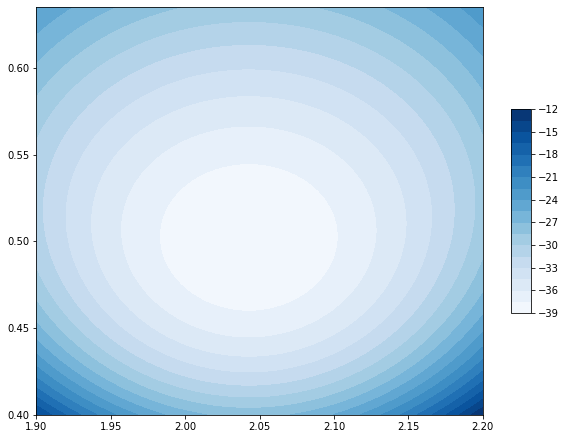

In [6]:
# plot cost function near minimum
# - ranges close to minimum
minx = 1.9
maxx = 2.2
miny = 0.4
maxy = 0.64
# get Z data for grid
X, Y, Z = get_3Dfunction_data(xmin=minx, xmax=maxx, ymin=miny, ymax=maxy,
                              func=plotEfficient_myCost, delta=0.005)
minz = np.amin(Z)
maxz = np.amax(Z)

# create figure ...
fig = plt.figure(figsize=(10., 7.5))
# ... plot (filled) contour lines ...
cont = plt.contourf(X, Y, Z, cmap='Blues', levels=25)
# ... and add a legend 
cbar=plt.colorbar(cont, shrink=0.5, aspect=10)

### Alternative Methode zur Bestimmung der Parameterunsicherheiten: Profil-Likelihood

Bei nicht Gauß-förmigen Unsicherheiten der Messdaten und kleinen Stichproben 
ist der Verlauf am Minimum nicht mehr gut durch eine Parabel anzunähern, und 
die Angabe eines aus den zweiten Ableitungen am Punkt des Minimums beruhenden
symmetrischen Intervalls für die Unsicherheiten ist dann häufig nicht mehr 
ausreichend. 
In solchen Fällen verwendet man zur Abschätzung des Vertrauensintervalls der Parameter 
einen Scan der sog. **Profil-Likelihood**. 
Bei diesem Verfahren wird für jeden Parameter eine Anzahl von dicht in der Nähe des
Minimums liegenden Punkten betrachtet und die log-Likelihood bezüglich aller übrigen 
Parameter minimiert. Auf diese Weise werden insbesondere auch die Korrelationen mit
anderen Parametern berücksichtigt. Das Vertrauensintervall, das dem Bereich plus/minus 
einer Standardabweichung einer Gaußverteilung um den Parameterwert, also
einem Konfidenzniveau von 68.3% entspricht, erhält man an den Stellen,
an denen die log-Likelihood um den Wert $\frac{1}{2}$ größer ist als
am Minimum (bzw. um Eins größer, wenn man $-2\ln(\cal L)$ verwendet). 
Für parabolische Verläufe ist das Verfahren zur auf den zweiten 
Ableitungen basierenden Methode äquivalent; bei nicht-parabolische Verläufen 
ergibt sich aus der Analyse der Profil-Likelihood ein asymmetrisches Konfidenzintervall
um den Parameterwert am Minimum, das in solchen Fällen an Stelle der aus den zweiten 
Ableitungen am Minimum bestimmen Schätzungen der Standardabweichungen der Parameter
angegeben werden sollte.

Das Prinzip der Profil-Likelihood lässt sich auch in zwei Dimensionen,
also für Paare von Parametern, anwenden. Man erhält dann Konturlinien,
die Konfidenzbereichen analog zu ein- oder auch zwei-$\sigma$-Konturen von 
Gauß-förmigen Verteilungen entsprechen. Bei starker Abweichung der Konturen 
von der Ellipsenform sollten sie zusammen mit dem Ergebnis berichtet werden.

Profile-Likelihood-Kurven und Konfidenzkonturen lassen sich mit dem oben 
gezeigten Code leicht erzeugen, wenn die zusätzliche Option `plot_cor=True`
angegeben wird:

<Figure size 432x288 with 0 Axes>

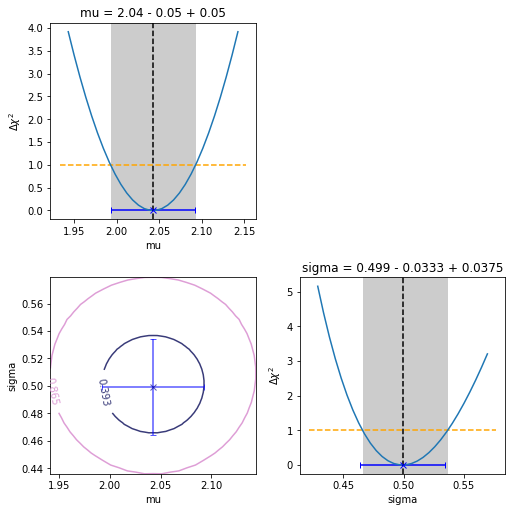


*==* user-defined cost: Fit Result:
 parameter names:        ('mu', 'sigma')
 parameter values:       [2.04270359 0.49920607]
 neg. parameter errors:  [-0.05004574 -0.03330733]
 pos. parameter errors:  [0.05004667 0.03750804]
 correlations : 
 [[1.00000000e+00 2.16470393e-04]
 [2.16470393e-04 1.00000000e+00]]


In [7]:
fit_results = mFit(myCost, plot_cor=True)

# Print results
pvals, perrs, cor, gof, pnams = fit_results.values()
print('\n*==* user-defined cost: Fit Result:')
print(" parameter names:       ", pnams)
print(" parameter values:      ", pvals)
print(" neg. parameter errors: ", perrs[:,0])
print(" pos. parameter errors: ", perrs[:,1])
print(" correlations : \n", cor)  


In den mit dem Code oben erzeugten Matrix aus Grafiken werden auf der Diagonalen die
Verläufe der Profil-Likelihood angezeigt; in den unteren Nebendiagonalelementen sind
die 1- und 2-$\sigma$ Konturen dargestellt. Die Fehlerbalken sind die aus der Analyse
der zweiten Ableitungen gewonnenen Unsicherheiten, die in diesem Fall gut mit 
den mit Hilfe der Profil-Likelihood bestimmten Konfidenzintervallen übereinstimmen. 

### Beispiel 2: log-Likelihood Anpassung einer Exponentialfuntion

Wir wollen nun ein etwas komplexeres, realistisches Beispiel zur Anpassung von
Parametern an Daten mit Hilfe des Maximum-Likelihood Verfahrens anschauen. 

Dazu verwenden wir echte Messungen der Lebensdauern von gestoppten 
kosmischen Myonen, die in einem Wasser-Cherenkov-Detektor (in diesem Fall 
einer Kaffeekanne mit Photomultiplier) nachgewiesen wurden. Beim Durchgang 
durch das Wasser erzeugen die Myonen ein Lichtsignal; wenn sie im Wasser
oder im Boden darunter gestoppt werden, können Elektronen aus den zerfallenden
Myonen wieder in den Detektor gelangen und nachgewiesen werden. Die Daten
entsprechen den Zeitdifferenzen (in µs) solcher Doppelpulse. Zufällig
eintreffende Myonen, Umgebungsstrahlung und evtl. Detektorrauschen erzeugen 
ebenfalls Doppelpulse, die im Gegensatz zu den Lebensdauern aber flach verteilt
sind und einen Untergrund bei der Lebensdauermessung darstellen.

Die relevante, auf Eins normierte Verteilungsdichte und die Daten finden 
sich in der folgenden Code-Zelle:

In [8]:
def exponentialDecayPDF(t, tau=2., fbg=0.2, a=1., b=11.5):
  """Probability density function 

    for an exponential decay with flat background. The pdf is normed for the interval 
    [a=1µs,  b=11.5µs); these parameters a and b must be fixed in the fit! 
  """

  # 1.) Exponential distribution of life time measuremtens in the intervall [a, b]
  pdf1 = np.exp(-t / tau) / tau / (np.exp(-a / tau) - np.exp(-b / tau))

  # 2. flat distribution in the interval [a, b]
  pdf2 = 1. / (b - a)

# the full distribution is a combinatin of both, with a background fraction fbg   
  return (1 - fbg) * pdf1 + fbg * pdf2


# real data from measurement with a Water Cherenkov detector ("Kamiokanne")
dT=[7.42, 3.773, 5.968, 4.924, 1.468, 4.664, 1.745, 2.144, 3.836, 3.132,
    1.568, 2.352, 2.132, 9.381, 1.484, 1.181, 5.004, 3.06,  4.582, 2.076,
    1.88,  1.337, 3.092, 2.265, 1.208, 2.753, 4.457, 3.499, 8.192, 5.101,
    1.572, 5.152, 4.181, 3.52,  1.344, 10.29, 1.152, 2.348, 2.228, 2.172,
    7.448, 1.108, 4.344, 2.042, 5.088, 1.02,  1.051, 1.987, 1.935, 3.773,
    4.092, 1.628, 1.688, 4.502, 4.687, 6.755, 2.56,  1.208, 2.649, 1.012,
    1.73,  2.164, 1.728, 4.646, 2.916, 1.101, 2.54,  1.02,  1.176, 4.716,
    9.671, 1.692, 9.292, 10.72, 2.164, 2.084, 2.616, 1.584, 5.236, 3.663,
    3.624, 1.051, 1.544, 1.496, 1.883, 1.92,  5.968, 5.89,  2.896, 2.76,
    1.475, 2.644, 3.6,   5.324, 8.361, 3.052, 7.703, 3.83,  1.444, 1.343,
    4.736, 8.7,   6.192, 5.796, 1.4,   3.392, 7.808, 6.344, 1.884, 2.332,
    1.76,  4.344, 2.988, 7.44,  5.804, 9.5,   9.904, 3.196, 3.012, 6.056,
    6.328, 9.064, 3.068, 9.352, 1.936, 1.08,  1.984, 1.792, 9.384, 10.15,
    4.756, 1.52,  3.912, 1.712, 10.57, 5.304, 2.968, 9.632, 7.116, 1.212,
    8.532, 3.000, 4.792, 2.512, 1.352, 2.168, 4.344, 1.316, 1.468, 1.152,
    6.024, 3.272, 4.96, 10.16,  2.14,  2.856, 10.01, 1.232, 2.668, 9.176 ]


Die Anpassung mit Hilfe des log-Likelihood-Verfahrens funktioniert genau so 
wie oben. Dieses Mal werden allerdings an Stelle der Kostenfunktion die Daten
und die Verteilungsdichte sowie weitere Optionen zur grafischen Darstellung 
als Parameter angegeben. Damit die Anpassung funktioniert, muss das
Anpassungswerkzeug einige besondere Optionen unterstützen: 
- die Begrenzung von Parametern auf einen sinnvollen Bereich   
  (Option `limits=('fbg', 0., 1.)`) und 
- die Fixierung von Paramtern, die in der Anpassung nicht variiert werden. 
  In diesem Fall ist dies das Intervall, in dem die Messungen verlässlich sind
  und auf das die Verteilungsdichte normiert ist      
  (Option `fixPars = ['a', 'b']`).
  
Hier nun der vollständige Programmcode zur Anpassung einer Verteilungsdichte
an (ungebinnte) Daten:

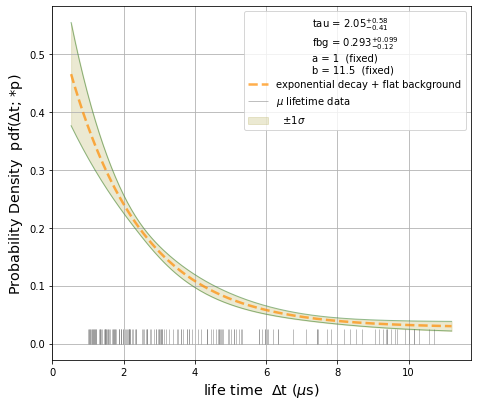

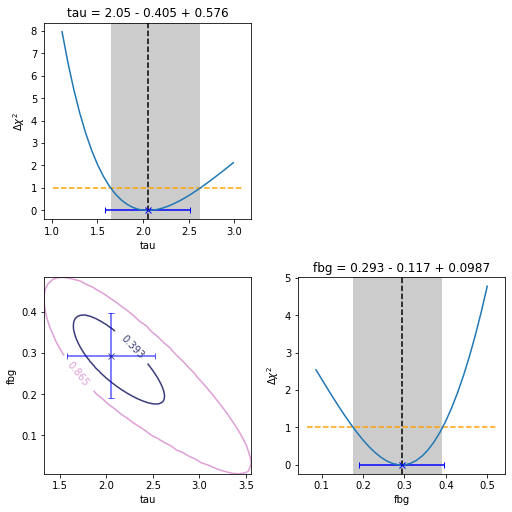


*==* unbinned ML Fit Result:
 parameter names:        ['tau' 'fbg' 'a' 'b']
 parameter values:       [ 2.04952279  0.29330093  1.         11.5       ]
 neg. parameter errors:  [-0.40510342 -0.1168369 ]
 pos. parameter errors:  [0.57553675 0.09874637]
 correlations : 
 [[ 1.         -0.77785875]
 [-0.77785875  1.        ]]


In [9]:
results = mFit( exponentialDecayPDF,
       data = dT, # data - if not None, a normalised PDF is assumed as model  
       limits=('fbg', 0., 1.),  # parameter limits
       fixPars = ['a', 'b'],    # fix parameter(s) 
       neg2logL = True,         # use  -2 * ln(L)
       plot=True,               # plot data and model
       plot_band=True,          # plot model confidence-band
       plot_cor=True,          # plot profiles likelihood and contours
       axis_labels=['life time  ' + '$\Delta$t ($\mu$s)', 
                       'Probability Density  pdf($\Delta$t; *p)'], 
       data_legend = '$\mu$ lifetime data',    
       model_legend = 'exponential decay + flat background' )

# Print results 
pvals, perrs, cor, gof, pnams = results.values()
print('\n*==* unbinned ML Fit Result:')
print(" parameter names:       ", pnams)
print(" parameter values:      ", pvals)
print(" neg. parameter errors: ", perrs[:,0])
print(" pos. parameter errors: ", perrs[:,1])
print(" correlations : \n", cor)  


Anders als bei der Anpassung der Gaußverteilung an Gauß-verteilte Daten zeigen die Profil-Likelihood
und die Konturen in diesem Fall eine starke Abweichung von linearem Verhalten. 
In einem solchen Fall ist die Bereitstellung der Grafiken zusätzlich zur Angabe der numerischen Ergebnisse notwendig. Auch die stark asymmetrischen Unsicherheiten müssen unbedingt angegeben werden.  

***

## 3. Anpassung von Verteilungsdichten an Histogramme
***

Ein weiteres typisches Beispiel für die Anwendung der log-Likelihood-Methode
ist die Behandlung von Problemen, bei denen Poisson-verteilte Größen
auftreten. Dies sind z.$\,$B. die Anzahlen von Einträgen in einzelnen
Intervallen von Häufigkeitsverteilungen (Histogramme).

Die Poissonverteilung von Anzahlen $n_i$ mit Erwartungswerten $\mu_i$
ist gegeben durch

\begin{equation}\label{equ-Poisson}
  P(n_i;\mu_i)=\frac{{\mu_i}^{n_i}} {n_i\,!} \, {\rm e}^{-\mu_i} \,.
\end{equation}

Durch Bilden des Produkts über alle (als statistisch unabhängig
angenommenen) $n_b$ Bins eines Histogramms erhält man die Likelihood 

\begin{equation}\label{equ-LPoisson}
  {\cal{L}}_{Poisson}=\displaystyle\prod_{i=1}^{n_b}
  {\rm P}\left(n_i;\mu_i(\vec p)\right)\, ,
\end{equation}

und schließlich durch Logarithmieren und Weglassen des nicht von den 
Parametern abhängigen Terms $\ln(n!)$ die negative log-Likelihood der
Poisson-verteilten Anzahlen der Einträge in den Bins eines Histogramms
\begin{equation}\label{equ-nlLPoisson}
nl{\cal{L}}_{Poisson}= -\ln {\cal{L}}_{Poisson} =
\displaystyle\sum_{i=1}^{n_b} - n_i \cdot \ln(\mu_i(\vec p))\,+\,\mu_i(\vec p) \,.
\end{equation}

Bei Verwendung dieser Kostenfunktion im Minimierungsprozess können
Anpassungen von Verteilungsdichten an Histogramme ganz analog wie bei
der Verwendung der oben bereits diskutierten Likelihood zur Anpassung
von Verteilungsdichten an Messdaten durchgeführt werden, die in diesem
Fall aber als Histogramm vorliegen. 
Der Rechenaufwand hängt in diesem Beispiel von der Zahl der Bins und
nicht - wie im ersten Beispiel - von der Größe des Datensatzes ab. 

Die Anzahl der auf Grund der Verteilungsdichte erwarteten Einträge $n_i$ 
bestimmt man sinnvollerweise durch Bildung des Integrals der Verteilung
über die Binbreite - eine numerische Näherung (z.B. Simpson 2. Ordnung)
ist meist ausreichend. 

In manchen Fällen wird auch eine Gauß-Näherung der Poisson-Verteilung
verwendet,  $P(n_i;\mu_i) = Gauss(n_i, \mu_i, \sigma=\sqrt{\mu_i})$.
Bei großen Anzahlen an Bin-Einträgen ist diese Näherung akzeptabel und
erlaubt häufig die Anwendung von Programmen zur Anpassung, die auf
der Methode der kleinsten Fehlerquadrate beruhen und daher nur eine
auf der Gaußverteilung beruhende Kostenfunktion erlauben. 

Wichtig ist es, die Schätzung der Unsicherheiten $\sigma_i = \sqrt{\mu_i}$
aus der Modellerwartung und nicht aus den beobachteten Werten in den
Daten zu bestimmen, da letzteres zu einer verzerrten Parameterschätzung
führen würde und Bins mit Null Einträgen sogar weggelassen werden müssten. 
Im Notfall kann man sich behelfen, indem zunächst eine Anpassung mit den aus
der Beobachtung gewonnenen Unsicherheiten durchgeführt wird, die in 
einer wiederholten Anpassung durch die aus der dann näherungsweise bekannten 
Modellerwartung gewonnenen Werte ersetzt werden.
Bei den empfohlenen Werkzeugen *kafe2* und *phyFit* sind solche Umstände
allerdings nicht notwendig, da sie das korrekte, oben skizzierte 
Likelihood-Verfahren für die Anpassung an Histogrammdaten nutzen. 



### Beispiel: Anpassung an Histogramm-Daten

Die Anpassung eines Modells an histogrammierte Daten wird durch die Funktion
*hFit()* aus dem Paket *PhyPraKit.phyFit* unterstützt. Die Vorgehensweise ist ganz
analog zur Anpassung von ungebinnten Daten. Von Anwenderseite müssen lediglich
die Daten und die Verteilungsdichte bereit gestellt sowie Angaben zu den 
Ausgabeoptionen gemacht werden. Die passenden Kostenfunktionen, also das zweifache
des negativen natürlichen Logarithmus der Poissonverteilung - oder, oft in 
ausreichender Näherung der Gaußverteilung - sind in *hFit* implementiert. 

Hier das vollständige Progammbeispiel:

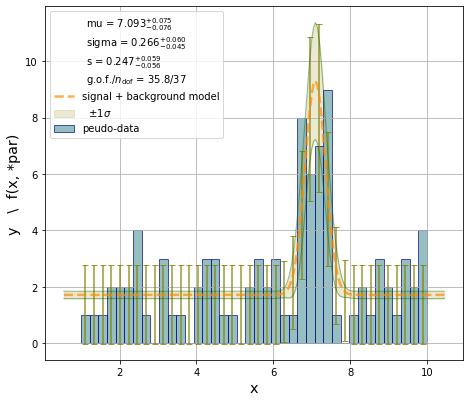

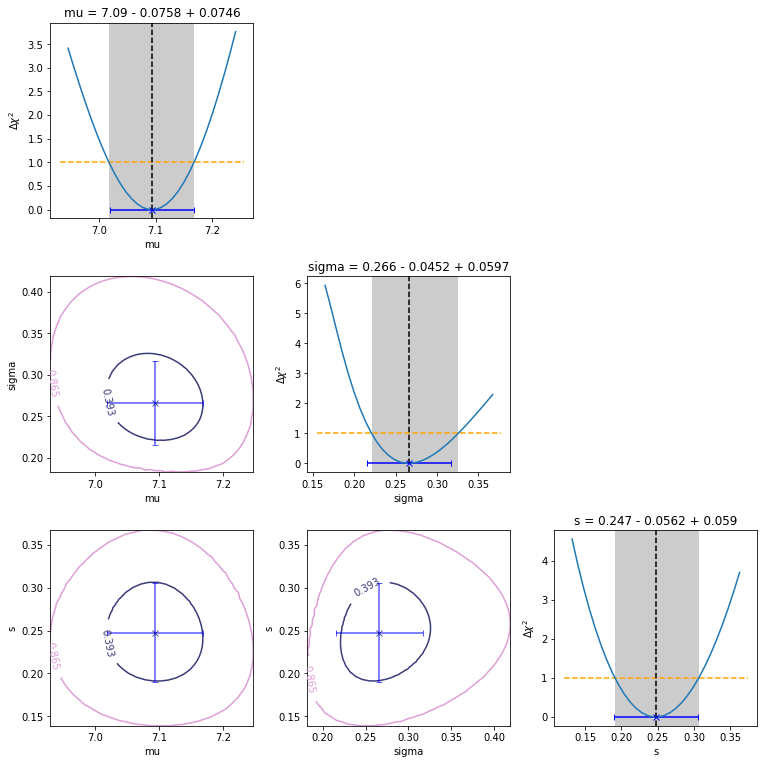


*==* histogram fit Result:
 parameter names:        ('mu', 'sigma', 's')
 goodness-of-fit: 35.8
 parameter values:       [7.09319061 0.26610602 0.24736214]
 neg. parameter errors:  [-0.07576898 -0.04516454 -0.05622502]
 pos. parameter errors:  [0.07458932 0.05972126 0.05896517]
 correlations : 
 [[ 1.         -0.12026333 -0.04426505]
 [-0.12026333  1.          0.12765636]
 [-0.04426505  0.12765636  1.        ]]


In [10]:
from PhyPraKit.phyFit import hFit

#  the model function to fit
def SplusB_model(x, mu = 6.987, sigma = 0.5, s = 0.2):
  '''pdf of a Gaussian signal on top of flat background
  '''
  normal = np.exp(-0.5*((x-mu)/sigma)**2)/np.sqrt(2.*np.pi*sigma**2)
  linear = 1. / (xmx-xmn) 
  return s * normal + (1-s) * linear 

nbins=40
xmn = 1
xmx = 10
bedges=np.linspace(xmn, xmx, nbins+1)
bcontents = np.array([1, 1, 1, 2, 2, 2, 4, 1, 0, 3, 1, 1, 0,
                        2, 3, 3, 1, 1, 0, 2, 3, 2, 3, 1, 1, 8,
                        6, 7, 9, 1, 0, 1, 2, 1, 3, 2, 1, 3, 2, 4])
#  
# ---  perform fit  
#
results = hFit(SplusB_model,
    bcontents, bedges,      # bin entries and bin edges
    limits=[('s', 0., None), ('sigma', 0., None)], # parameter limits
    plot=True,              # plot data and model
    plot_band=True,         # plot model confidence-band
    plot_cor=True,          # plot profiles likelihood and contours
    axis_labels=['x', 'y   \  f(x, *par)'], 
    data_legend = 'peudo-data',    
    model_legend = 'signal + background model' )

# Print results 
# pnams, pvals, perrs, cor, chi2 = results
print('\n*==* histogram fit Result:')
print(" parameter names:       ", results['parameter names'])
print(" goodness-of-fit: {:.3g}".format(results['goodness-of-fit']))
print(" parameter values:      ", results['parameter values'])
print(" neg. parameter errors: ", results['confidence intervals'][:,0])
print(" pos. parameter errors: ", results['confidence intervals'][:,1])
print(" correlations : \n", results['correlation matrix'])


Die grafische Ausgabe zeigt die angepasste Verteilungsdichte sowie deren Unsicherheit, die durch 
Propagation der Paramerunsicherheiten auf die Modellvorhersage bestimmt wird. 
Die rechteckigen Flächen repräsentieren die Zahl der in den Daten beobachteten Einträge und 
entsprechen der klassischen Histogramm-Darstellung. Die um die Modellfunktion eingezeichneten
Fehlerbalken zeigen den 68.3%-Konfidenzbereich für die unter Zugrundelegung der Poission-Verteilung
erwartete Zahl an Einträgen in jedem Bin. Die Größe "g.o.f" (= "goodness of fit") ist die 
Differenz des beobachteten Werts von $n2l{\cal L}$ und dem bestmöglichen Wert dieser Größe, 
den man erhält, wenn alle Daten auf der Modellvorhersage liegen, dem sog. "Saturated Model"; 
g.o.f. konvergiert für große Datensätze gegen die aus der Anpassung mit der Methode der kleinsten
Fehlerquadrate bekannte Größe $\chi^2$.

Ein **Vergleich mit der Gauß-Näherung** ist durch Angabe einer weiteren Option
`use_GaussApprox=True` beim Aufruf von *hFit* leicht möglich. Hier das gleiche
Beispiel, bei dem im Vergleich zu vorhin nur diese Option geändert wurde. 

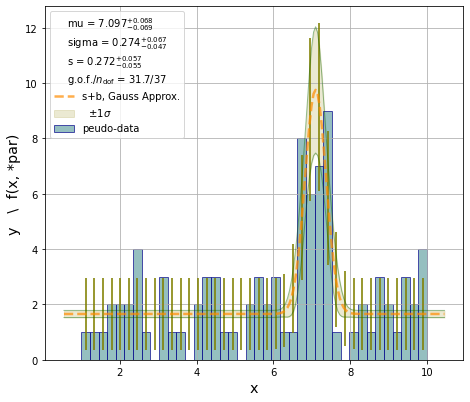

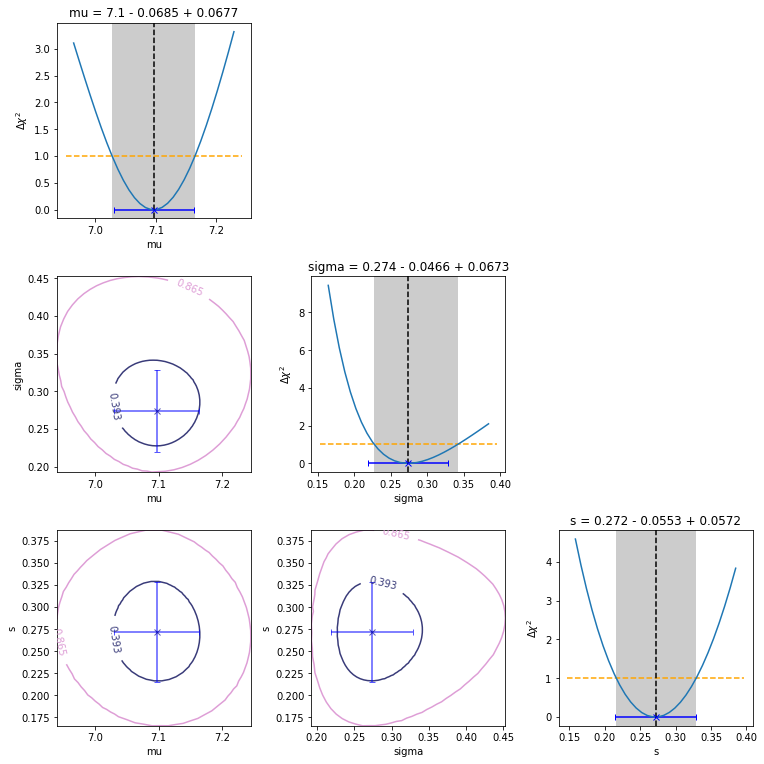


*==* histogram fit with Gaussian cost:
 parameter names:        ('mu', 'sigma', 's')
 goodness-of-fit: 31.7
 parameter values:       [7.09681353 0.27407023 0.27181286]
 neg. parameter errors:  [-0.06854522 -0.04662249 -0.0553459 ]
 pos. parameter errors:  [0.06773086 0.06732895 0.05723184]
 correlations : 
 [[ 1.         -0.01498253 -0.03844071]
 [-0.01498253  1.          0.00572968]
 [-0.03844071  0.00572968  1.        ]]


In [11]:
#  
# ---  perform 2nd Fit with Gaussian cost function  
#
results = hFit(SplusB_model,
    bcontents, bedges,      # bin entries and bin edges
    limits=[('s', 0., None), ('sigma', 0., None)], # parameter limits
    use_GaussApprox=True,   # use Gaussian approxmiation of Poisson distr.
    plot=True,              # plot data and model
    plot_band=True,         # plot model confidence-band
    plot_cor=True,          # plot profiles likelihood and contours
    axis_labels=['x', 'y   \  f(x, *par)'], 
    data_legend = 'peudo-data',    
    model_legend = 's+b, Gauss Approx.' )

# Print results 
# pnams, pvals, perrs, cor, chi2 = results
print('\n*==* histogram fit with Gaussian cost:')
print(" parameter names:       ", results['parameter names'])
print(" goodness-of-fit: {:.3g}".format(results['goodness-of-fit']))
print(" parameter values:      ", results['parameter values'])
print(" neg. parameter errors: ", results['confidence intervals'][:,0])
print(" pos. parameter errors: ", results['confidence intervals'][:,1])
print(" correlations : \n", results['correlation matrix'])




***
## 4. Maximum-Likelihood und Methode der kleinsten Fehlerquadrate
***

Die Methode der kleinsten Fehlerquadrate zur Anpassung von Modellen ist
ein Spezialfall des maximum-Likelihood Verfahrens.

Zunächst leiten wir ein auf der log-Likelihood Methode basierendes
Anpassungsverfahren für Modellfunktionen an Messdaten her.
Wir bezeichnen die zufällige Abweichung eines Messwertes vom wahren
Wert mit $z$, die durch eine Verteilungsdichte $f_z$
beschrieben wird. Im Falle von Messunsicherheiten ist $f_z$ häufig
die Normalverteilung mit Erwartungswert Null und Standardabweichung $\sigma$,
${\cal N}(z; \sigma)$. Im mehrdimensionalen Fall für $n_d$ nicht
notwendigerweise unabhängige Datenpunkte ist die multivariate
Gaußverteilung ${\cal N}(\vec z; V)$ mit der Kovarianzmatrix $V$ relevant,

\begin{equation}\label{equ-mStandardGauss}
  {\cal{N}}\left(\vec{z}, V) \right) = 
\frac{1} {\sqrt{(2\pi)^{n_d} \det(V)} }
\cdot
\exp \left( -\frac{1}{2} \vec{z}^T V^{-1} \vec{z}
\right) \,.
\end{equation}

Die Zufallsgröße $z$ mit Erwartungswert Null entspricht den Fluktuationen 
um den wahren Wert. Wenn es für den wahren Wert eine exakte theoretische 
Erwartung in Form eines parameterbehafteten Modells $f_i(\vec p)$ mit einem 
Satz an Parametern $\vec p$ gibt, lässt sich ein Messwert $y_i$ schreiben als
\begin{equation}\label{equ-zplusw}
y_i =  f_i(\vec p) + z_i \,.
\end{equation}

Üblicherweise führt man zum Test von parameterbehafteten, durch
Funktionen beschriebenen Modellen mehrere Messungen an verschiedenen
Stützstellen $x_i=(\vec x)_i$ durch, man betrachtet also eine Modellfunktion
$f(\vec x; \vec p)$.
Die Verteilungsdichte, die alle Messungen beschreibt, sieht dann so aus:

\begin{equation}\label{equ-mGauss}
  {\cal{N}}\left(\vec{y}, V, f(\vec{x}, \vec{p}) \right) = 
  \frac{1} {\sqrt{(2\pi)^{n_d} \det(V)} } \cdot
  \exp\left( -\frac{1}{2} (\vec{y}-\vec{f})^T V^{-1} (\vec{y}-\vec{f}) \right) \,.
\end{equation}

Nach dem Maximum-Likelihood-Prinzip ist der beste Parametersatz durch
den Punkt $\hat{\vec{ p}}$ im Parameterraum gegeben, für den die Likelihood
maximal wird. Wie schon oben verwendet man das Zweifache des negativen natürlichen
Logarithmus der Likelihood, $n2l{\cal L}_{Gauss}$, der dann minimiert wird.
\begin{equation}\label{equ-nlLGauss}
-2\, \ln{\cal{L_{\rm Gauß}}}\left( \vec y, V, \vec{f}(\vec x, \vec {p}) \right)
\,=\, \left(\vec y - \vec f(\vec x; \vec p ) \right)^T V^{-1}
  \left(\vec y - \vec f(\vec x; \vec p ) \right)
  + \ln(\det(V)) + n_d\,\ln(2\pi) \,.
\end{equation}

Für die Bestimmung des Minimums von $n2l{\cal L}_{Gauss}$ sind bzgl. der
Parameter konstante Terme nicht relevant, man kann sie daher weglassen.
Wenn die Normierung der Gaußverteilung, also der Term $\det(V)$, nicht
von den Parametern abhängt, vereinfacht sich der obige Ausdruck
zum altbekannten Ausdruck für die quadratische Residuensumme mit 
Kovarianzmatrix, $S$:

\begin{equation}\label{equ-chi2}
S\left(\vec y, V, \vec{f}(\vec x, \vec {p})\right) \,=\,
  \left(\vec y - \vec f(\vec x; \vec p ) \right)^T V^{-1}
  \left(\vec y - \vec f(\vec x; \vec p ) \right) \,.
\end{equation}

Unter speziellen Bedingungen sind also die Minimierung von 
$n2l{\cal{L}}$ und der quadratischen Summe der Residuen $S$ 
äquivalent. 
Dieser einfache Fall ist aber nicht mehr gegeben, wenn relative, 
auf den Modellwert bezogene Unsicherheiten auftreten, oder wenn 
Unsicherheiten in Abszissen-Richtung behandelt werden sollen, die 
mit Hilfe einer Taylor-Entwicklung erster Ordnung von der Abszisse 
auf die Ordinate übertragen werden und damit von der Ableitung des 
Modells nach $x$ und so auch von den Parameterwerten abhängen.
Die praktische Regel lautet daher, möglichst immer die Likelihood
zu verwenden, und nur in gut begründeten, berechtigten Fällen
auf die Methode der kleinsten Fehlerquadrate zurück zu greifen.
Allerdings ist man bei der Wahl der verfügbaren numerischen
Werkzeuge stark eingeschränkt, wenn man diese Empfehlung
umsetzen möchte.

Sollen Problemstellungen mit nicht Gauß-förmigen Verteilungen
behandelt werden, ist die Verwendung von log-Likelihoodverfahren
unumgänglich. Das Aufstellen entsprechender Likelihood-Funktionen
zur Behandlung spezieller Problemstellungen gehört in der
wissenschaftlichen Praxis heute zum Standard. Dank sehr leistungsfähiger
Algorithmen zur numerischen Minimierung in hoch-dimensionalen
Parameterräumen und auch Dank moderner Computertechnik stellt
die Verwendung korrekter Likelihood-Verfahren kein
unüberwindliches Problem mehr dar.

### Pratkische Hinweise

In der Praxis sind die oben beschriebenen Verfahren nur in Kombination mit 
numerischen Verfahren zur Minimierung von skalaren Funktionen in mehr- oder
sogar hoch-dimensionalen Räumen und Programmcode zur Verwaltung der Daten
und ihrer Unsicherheiten durchführbar. Obwohl in seltenen Fällen auch analytische
Lösungen existieren, nutzt man in der Praxis fast ausschließlich Programmpakete
zur Durchführung von Anpassungen; analytische (Teil-)Lösungen müssen nur
eingesetzt werden, wenn es um zeitkritische Problemstellungen geht. 

#### Konstruktion der Kovarianzmatrix

Die Kovarianzmatrix der Daten bildet die Unsicherheiten Gauß-verteilter 
Eingabedaten vollständig ab. Wird sie bei der Anpassung berücksichtigt, 
werden alle zwischen den Daten unabhängigen und korrelierten Unsicherheiten
beim Anpassungprozess in das Endergebnis propagiert - eine klassische 
Fehlerrechnung von Hand ist dann nicht mehr notwendig. 

Fassen wir zunächst kurz die wesentlichen Eigenschaften der
Kovarianzmatrix ${\bf V}$ zusammen:

- ${\bf V} = \left(\mathrm{V}_{ij}\right)$ ist eine symmetrische Matrix;
- sie hat die Dimension $n_d$, die der Anzahl der Messwerte entspricht;
- für unabhängige Messwerte ist die Matrix diagonal;
- die Nebendiagonalelemente $V_{ij},\,{\small i\ne j}$ lassen sich verstehen als
  das Produkt der gemeinsamen Unsicherheiten $\sigma^g_i$ und $\sigma^g_j$ der 
   Messungen $i$ und $j$;
- die Kovarianzmatrix-Elemente für voneinander unabhängige Unsicherheiten
  werden addiert.

Gerade der letzte Punkt ist von entscheidender Bedeutung, denn er erlaubt es,
die vollständige Kovarianzmatrix sukzessive aus einzelnen Beiträgen zur
Unsicherheit aufzubauen, mit der Konstruktionsvorschrift:

- Unsicherheiten der Messwerte werden nach verschiedenen, unabhängigen
  Quellen aufgeschlüsselt.
- Unabhängige Unsicherheiten jeder einzelnen Messung werden quadratisch in
  den Diagonalelementen aufaddiert.
- Allen Messwerten oder Gruppen von Messungen gemeinsame absolute oder
  relative Unsicherheiten werden quadratisch in den betreffenden
  Diagonal- und Nebendiagonalelementen $V_{ii}$, $V_{jj}$ und $V_{ij}$ aufaddiert.

Unsicherheiten in Abszissenrichtung, gegeben durch eine Kovarianzmatrix
${\bf V}^x$, können berücksichtigt werden, in dem man mit sie Hilfe der
Modellvorhersage $f(\vec x, \vec p)$ per Taylor-Entwicklung in erster Ordnung
in y-Richtung transformiert und dann zur Kovarianz-Matrix der Datenpunkte in
y-Richtung, ${\bf V}^y$, addiert:

\begin{equation}\label{equ-xyCovariance}
  V_{ij} = (V^y)_{ij} 
        +  \frac{\partial f}{\partial x_i} \frac{\partial f}{\partial x_j} (V^x)_{ij} 
\end{equation}

Insgesamt ergeben sich so acht Arten von Unsicherheiten, nämlich 
unabhängige und / oder korrelierte
absolute und / oder relative Unsicherheiten in
$x$- und / oder $y$-Richtung.

Zum Bau der Kovarianzmatrix setzt man idealerweise Programmcode ein. Die
wenigsten gängigen Anpassungsprogramme bringen dafür direkt Optionen mit,
sondern es muss die vollständige Kovarianzmatrix als Parameter übergeben
werden.
Das Paket *kafe2* enthält die Methode   
`add_error(err_val, axis=?, correlation=?, relative=?, reference=?)`   
mit deren Hilfe einzelne Komponenten der Unsicherheit hinzugefügt werden
können. Die Interfaces zu verschiedenen Anpassungsprogrammen
im Paket *PhyPraKit* sehen ebenfalls die Angabe einzelner Komponenten
der Unsicherheit als Parameter vor, wenn die entsprechenden Anpassungspakete
dies unterstützen.
Alle acht Arten von Unsicherheiten können direkt nur mit *kafe2* oder 
mit *PhyPraKit.phyFit* behandelt werden. 

#### Berücksichtigung externer und eingeschränkter Parameter

Häufig hängen Modellfunktionen von externen, mit Unsicherheiten behafteten 
Parametern ab, die z.$\,$B. in einer Hilfsmessung bestimmt wurden oder aus der
Literatur stammen. Dies können die Ergebnisse von Kalibrationsmessungen sein,
oder auch Natur- oder Apparatekonstanten. Statt die Effekte der Parameterunsicherheiten 
mit Hilfe einer händischen Fehlerrechnung auf das Endergebnis zu propagieren, 
können  sie auch als eingeschränkte Parameter ("constrained parameter") direkt 
in der Anpassung berücksichtigt werden. 
Dazu werden solche Parameter gleichzeitig als freie Parameter in der 
Anpassung und als Messgrößen eingeführt - d.$\,$h. ein entsprechender Term 
zur log-Likelihood hinzugefügt. 

Notwendig ist bisweilen auch eine Methode, mit deren Hilfe Parameter auf 
feste Werte fixiert werden können.
Der Einfluss externer Parameter kann damit auch untersucht werden, indem
man sie nacheinander auf ihren Erwartungswert und die jeweiligen oberen bzw. 
untere Grenzen ihres Konfidenzbereichs fixiert und die Veränderungen des 
Anpassungsergebnisses beobachtet.

Das temporäre Fixieren und wieder frei geben von Parametern kann auch hilfreich 
sein, wenn eine komplexe Anpassung nicht zum globalen Minimum konvergiert. Man 
kann dann einen oder einige Parameter in der Nähe des erwarteten Wertes fixieren 
und eine Minimierung bezüglich der übrigen Parameter vornehmen. Wenn man dann an 
diesem temporären Minimum die fixierten Parameter wieder frei gibt, sollte 
die Anpassung zum globalen Minimum konvergieren. 

Ein Problem während des Anpassungsprozesses stellen oft auch Parameter dar,
die temporär Werte in mathematisch nicht definierten Wertebereichen oder in 
unphysikalischen Bereichen annehmen (negative Werte unter Wurzeln, negative
Massen etc). Das Setzen von Limits zum Ausschluss solcher Parameterbereiche
ist eine wichtige Option für jedes Anpassungspaket. 

Bei nichtlinearen Problemstellungen gibt es häufig neben dem globalen Minimum
weitere Nebenminima - oder sogar mehrere oder viele gleichwertige Lösungen. 
In solchen Fällen werden Startwerte für die Parameter in der Nähe
einer "vernünftigen" Lösung benötigt. Auch diese Möglichkeit muss ein 
Anpassungspaket bieten. Da im Laufe des besseren Verständnisse aus manchem 
einfachen Problem später ein nichtlineares Problem werden kann, ist es eine 
gute Angewohnheit, grundsätzlich immer Startwerte zu setzen.


Ein Beispiel mit allen acht oben genannten Arten von Unsicherheiten ist in der Code-Zelle
unten gezeigt. Alle in der Funkion *xyFit* verfügbaren Optionen sind ebenfalls angegeben,
auch wenn für die meisten "vernünftige" Voreinstellungen gelten und man sich die explizite
Angabe häufig ersparen kann. 

### Beispiel zur Anpassung an x/y-Daten

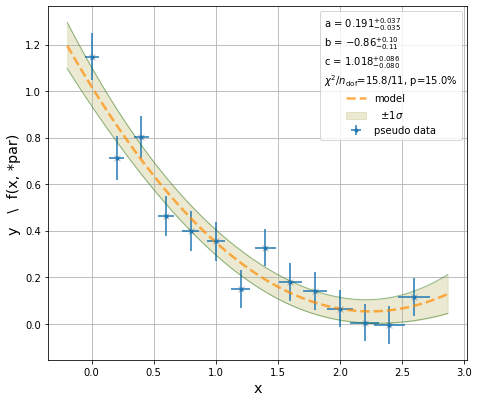

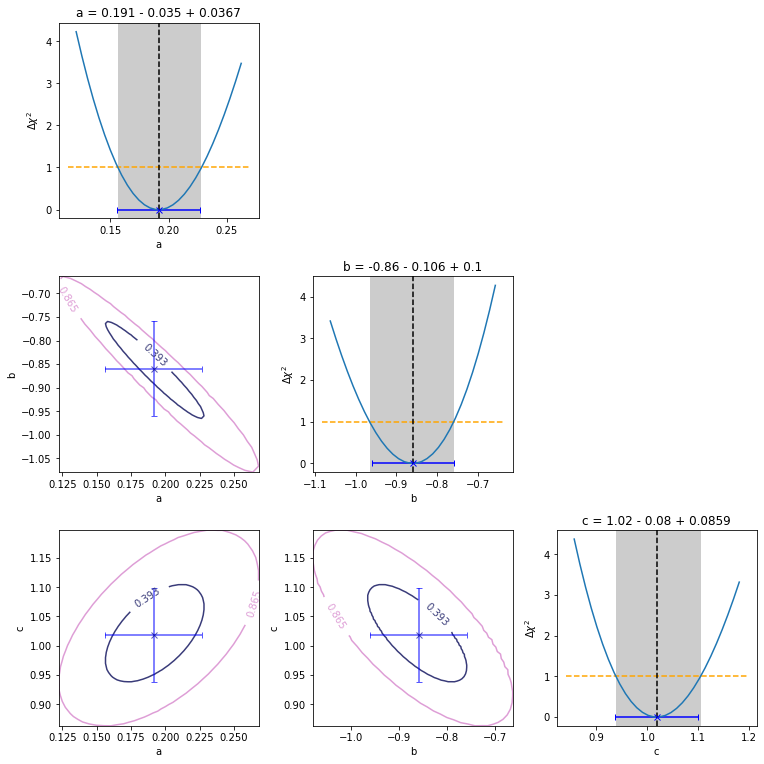


*==* xyFit Result:
parameter values
 [ 0.19147397 -0.85971999  1.01844637]
confidence intervals
 [[-0.03499509  0.03672393]
 [-0.10583673  0.10015959]
 [-0.08004777  0.08592092]]
correlation matrix
 [[ 1.         -0.95408115  0.5409451 ]
 [-0.95408115  1.         -0.70200198]
 [ 0.5409451  -0.70200198  1.        ]]
goodness-of-fit
 15.774326904277833
parameter names
 ('a', 'b', 'c')


In [12]:
 from PhyPraKit.phyFit import mnFit, xyFit

#
# *** Example of an application of phyFit.mFit()
#
# define the model function to fit
def exp_model(x, A=1., x0=1.):
  return A*np.exp(-x/x0)

# another model function
def poly2_model(x, a=0.1, b=1., c=1.):
  return a*x**2 + b*x + c

# set model to use in fit
#fitmodel=exp_model  # also try poly2_model !
fitmodel=poly2_model  # also try exp_model!
  
# the data ...
data_x = [0.0, 0.2, 0.4, 0.6, 0.8, 1., 1.2,
          1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
data_y = [1.149, 0.712, 0.803, 0.464, 0.398, 0.354, 0.148,
          0.328, 0.181, 0.140, 0.065, 0.005,-0.005, 0.116]
# ... and components of the uncertaity 
sabsy = 0.07 # independent y
srely = 0.05 # 5% of model value
cabsy = 0.04 # correlated
crely = 0.03 # 3% of model value correlated
sabsx = 0.05 # independent x
srelx = 0.04 # 4% of x
cabsx = 0.03 # correlated x
crelx = 0.02 # 2% of x correlated

# perform fit to data with function xyFit using class mnFit
results = xyFit(fitmodel,      # the model function
           data_x, data_y,     # x and y data
           sx=sabsx,           # the error components defined above
           sy=sabsy,
           srelx=srelx,
           srely=srely,
           xabscor=cabsx,
           xrelcor=crelx,
           yabscor=cabsy,
           yrelcor=crely,
#           p0=(1., 0.5),     # start values of parameters (taken from model if not given)
#           constraints=['A', 1., 0.03],    # constraint(s)
#           constraints=[0, 1., 0.03]       # alternative specificaiton of constraints
#           limits=('A', 0., None),  # parameter limits
#           fixPars = ['A'],         # parameter(s) to be fixed to start value 
           use_negLogL=True,         # use full n2lL (default)
           plot=True,                # plot data and model 
           plot_band=True,           # plot model uncerctainty
           plot_cor=True,            # plot profiels and contours
           quiet=True,               # silent output it True
           axis_labels=['x', 'y   \  f(x, *par)'], 
           data_legend = 'pseudo data',    
           model_legend = 'model')

# Print results 
print('\n*==* xyFit Result:')
for key in results:
  print("{}\n".format(key), results[key])



***
## 5. Beurteilung der Qualität von Anpassungsverfahren
***

An eine Parameterschätung werden bestimmte Anforderungen gestellt, die je nach gewähltem
Verfahren, aber auch abhängig von der Größe einer Stichprobe unterschiedlich gut erfüllt
sein könnnen. Da die Parameter $\hat{p}_i$ und ihre Unsicherheiten aus zufälligen Größen, 
den Daten, bestimmt werden, sind sie auch Zufallsgrößen mit Erwartungswerten 
$E[\hat{p}_i]$ und und Varianz $V[\hat{p}_i]$. 

Eine gute Parameterschätzung sollte folgende Eigenschaften haben:

  - konsistent: $\displaystyle \lim_{n \to \infty} \hat{p}_i = p_i$
  
  - möglichst erwartungstreu schon bei kleinen Stichproben: $E[\hat{p}_i] = p_i$   
  
  - möglichst unverzerrt: Verzerrung $b$ (=bias) $b_i=E[\hat{p}_i] - p_i$ =0,   
    für große Stichprobem muss wegen der geforderten Erwartungstreue gelten
    $\displaystyle \lim_{n \to \infty} b = 0$
  
  - optimal: $V[\hat{p}_i]$ minimal   
  
  - robust: unbeeinflusst von "Ausreißern" oder leichten Fehlmodellierungen der Daten
  
  - korrekte Überdeckungswahrscheinlichkeit (engl. "coverage"): 
    $W(p_i \in [\hat{p}_i - \Delta p_i, \hat{p}_i +\Delta p_i])= 68.3\%$  

Die hier diskutierte Maximum-Likelihood Methode (MLE) ist optimal, allerdings eher nicht
robust, weil falsche Annahmen über das Modell einen empfindlichen Einfluss auf die
Parameterwerte haben können. MLE-Schätzungen sind in der Regel auch nicht unverzerrt; 
wenn nicht unbedingt der Punkt der besten Anpassung ("Punktschätzung"), sondern, wie 
häufig in der Physik ein möglichst korrektes Konfidenzintervall ("Intervallschätzung") 
für den Schätzwert von Belang ist, spielt das allerdings eine untergeordnete Rolle. 
Wie wir schon oben gesehen hatten, existiert für die Bestimmung der Unsicherheiten nur 
eine Ungleichung (Cramér-Rao-Fréchet Grenze). Wie gut bestimme Verfahren typischerweise
nach den oben genannten Kriterien funktionieren, ist oft empirisch bekannt. Mann kann
zeigen, dass z.$\,$B. die Methode der kleinsten Fehlerquadrate für lineare Problemstellungen
und Gauß-förmige Messunsicherheiten optimal und unverzerrt ist. Die hier skizzierten
Likelihood-Verfahren erfüllen die oben genannten Bedingungen schon für recht kleine 
Stichproben ebenfalls gut. 

### Überprüfung mittels Monte-Carlo - Methode ("toy-MC")

Zur Überprüfung der Eigenschaften eines Schätzverfahrens und des Einflusses der Stichprobengröße
werden in der Praxis häufig Ensemble-Tests durchgeführt - d.h. man erzeugt zufällig eine große 
Anzahl gleichwertiger Stichproben und führt jeweils das Anpassungsverfahren durch.
Aus einer statistischen Analyse der Ergebnisse lassen sich dann die Eigenschaften des
Schätzverfahrens bestimmen.

Zur Simulation der Stichproben verwendet man die Monte-Carlo Methode; weil die Simulation
für diesen Zweck sehr einfach sein kann, nennt man solche Studien auch "toy-Monte Carlo".

Beispielcode zur Erzeugung künstlicher "Pseudo-Daten" ist in den folgenden Codezellen gezeigt.
Die durchgeführte Anpassung entspricht dem schon oben diskutierten Beispiel zur Anpassung
einer Modellfunktion an x/y-Daten mit verschiedenen Typen von Unsicherheiten. 


Hier der Code-Teil zur Definition aller Parameter zur Datenerzeugung und zur Anpassung:

In [13]:
from PhyPraKit import generateXYdata
from PhyPraKit.phyFit import xyFit, get_functionSignature
import matplotlib.pyplot as plt
from scipy import stats

# define some models to test
def exp_model(x, A=1., x0=1.):
  return A*np.exp(-x/x0)

# another model function
def poly2_model(x, a=0.75, b=1., c=1.):
  return a*x**2 + b*x + c

# set model to use ...
model = poly2_model
#model = exp_model

# ... and number of pseudo-experiments to perform
Nexp = 200

# parameters of pseudo-data
nd=120   # number of data points
xmin=0.  # x-range
xmax=2.5
data_x = np.linspace(xmin, xmax, nd)      # x of data points

# extract model paramerters from model function
mpardict = get_functionSignature(model)[1] # keyword arguments of model
true_vals = np.asarray(list(mpardict.values()))
npar=len(mpardict)
parnams = list(mpardict.keys())

# set uncertainties for x/y pseudo-data
# - independent absolute uncertainties
sabsx = 0.05 # 0.05
sabsy = 0.07 # 0.07 
# - indepentent relative uncertainties
srelx = 0.04 # 4%
srely = 0.03 # 5% of model value
# correlated uncertainties in x  and y direction 
cabsx = 0.03 # 0.03
crelx = 0.02 # 2%
cabsy = 0.04 # 0.04
crely = 0.03 # 3% of model value

# calulate total uncertainties
sigx = np.sqrt(sabsx * sabsx + (srelx * data_x)**2)
sigy = np.sqrt(sabsy * sabsy + (srely*model(data_x, **mpardict))**2)


# set keyword arguments for fit function xyFit
kw_uncertainties = {  # - components of uncertainty 
       'sx':sabsx,             # indep x
       'sy': sabsy,            # indel y
       'srelx': srelx,         # indep. rel. x
       'srely': srely,         # indep. rel. y
       'xabscor': cabsx,       # correlated x
       'xrelcor': crelx,       # correlated rel. x
       'yabscor': cabsy,       # correlated y
       'yrelcor': crely,       # correlated rel. y
       }

kw_options = {  # options for Fit
            'ref_to_model': True,   # reference of rel. uncert. to model
            'use_negLogL': True     # standard chi^2 if false
       }

Die Schleife zur Erzeugung der Daten, Modellanpassung und die Analyse der Ergebnisse 
ist in der folgenden Codezelle gezeigt. Für die  Analyse der individuellen Ergebnisse 
der Anpassung sind die folgenden Zeilen zuständig. Sie speichern die individuellen 
Ergebnisse, berechnen die $\chi^2$-Wahrscheinlichkeit, die Verzerrung und eine Bool'sche 
Variable für die Auswertung der Überdeckung zur späteren statistischen Auswertung:

```
 #  calculate chi2 probability
    chi2prb = 1.- stats.chi2.cdf(chi2, nd-len(pvals))
    c2prb.append(chi2prb)
    
    # analyze bias and coverage
    for i in range(npar):
      biases[i].append( pvals[i] - true_vals[i] )  # bias
      # get parameter confidence interval (CI)
      pmn = pvals[i] + perrs[i,0]
      pmx = pvals[i] + perrs[i,1]
      # coverage: count how often true value is in CI
      if (true_vals[i] >= pmn and true_vals[i]<=pmx): N_coverage[i] +=1
    else:                 
      # simple progress bar
      if (100*iexp)%Nexp==0: print('*', end='')
```


In [14]:
# this is the loop part of the MC simulation

def MC_loop():
  global nfail, biases, c2prb, N_coverage
  # initialize arrays for statistical analysis in loop
  nfail = 0                          # counter for failed fits
  biases = [[] for i in range(npar)] # bias
  c2prb = []                         # chi^2 probatility
  N_coverage = npar*[0]              # counters for coverage

#
# start toy-MC loop --------------------------------------------   
#
  print("generating data - patience please!")    
  for iexp in range(Nexp):
    #generate a sample of peudo-data
    np.random.seed(314159 + (iexp * 2718281)%100000)     # initialize random generator
    xt, yt, data_y = generateXYdata(data_x, model, sigx, sigy,
                                   xabscor=cabsx,
                                   xrelcor=crelx,
                                   yabscor=cabsy,
                                   yrelcor=crely,
                                   mpar=true_vals )
    # perform fit to pseudo data 
    try:
      plot = True if iexp < 1 else 0
      result = xyFit(model, data_x, data_y,      # model & data
         **kw_uncertainties, # all uncertainties 
         **kw_options,        # fit options
         plot=plot,           # plot data and model
         showplots=False      # call plt.show() in user code if False
      )

      # save fit results in local variables
      pvals, perrs, cor, chi2, pnams = result.values() 

      if plot:
        plt.suptitle('Result of fit {:d}'.format(iexp))

      if iexp < 1:
      # Print results to illustrate how to use output
        np.set_printoptions(precision=6)
        print('\n*==*  Fit {:d} Result:'.format(iexp))
        print(f" chi2: {chi2:.4g}")
        print(f" parameter names:  ", pnams)
        print(f" parameter values:  ", pvals)
        np.set_printoptions(precision=3)
        print(f" parameter errors: ", perrs)
        np.set_printoptions(precision=3)
        print(f" correlations : \n", cor)
        np.set_printoptions(precision=8) # default output precision
        print()
      else:                 
        # show simple progress bar
        if (100*iexp)%Nexp==0: print('*', end='')
                
      #  calculate chi2 probability
      chi2prb = 1.- stats.chi2.cdf(chi2, nd-len(pvals))
      c2prb.append(chi2prb)
    
      # analyze bias and coverage
      for i in range(npar):
        biases[i].append( pvals[i] - true_vals[i] )  # bias
        # get parameter confidence interval (CI)
        pmn = pvals[i] + perrs[i,0]
        pmx = pvals[i] + perrs[i,1]
        # coverage: count how often true value is in CI
        if (true_vals[i] >= pmn and true_vals[i]<=pmx): N_coverage[i] +=1

    except Exception as e:
      nfail +=1
      print('!!! fit failed ', nfail)
      print(e)
 

#### Auswertung der Ergebnisse

Die Code zur Analyse der in der Schleife aufgezeichneten Daten gibt zunächst die für
jeden der Parameter beobachtete Verzerrung aus, zusammen mit deren durch die endliche
Statistik bedingten Parameterunsicherheiten. Statistisch signifikant sind nur Verzerrungen, 
die deutlich größer als die Unsicherheit auf den Mittelwert der Abweichungnesind. Zur Bewertung
der Relevanz muss man sie in Bezug auf die Unsicherheit der Parameterwerte, also der Breite
der Verteilung der Abweichungen, setzen. Erst wenn sie eine bedeutsame Größe davon erreichen, 
typischerweise größer als 5% - 10%,  sollten die Verzerrungen angegeben werden. 

Als zweite Größe wird die Coverage ausgegeben, die dem Anteil der Fälle entspricht, in
denen der wahre Parameterwert innerhalb des Unsicherheitsintervalls liegt.

generating data - patience please!

*==*  Fit 0 Result:
 chi2: 101.6
 parameter names:   ('a', 'b', 'c')
 parameter values:   [0.704721 1.195344 0.968146]
 parameter errors:  [[-0.051  0.055]
 [-0.104  0.107]
 [-0.067  0.067]]
 correlations : 
 [[ 1.    -0.523  0.359]
 [-0.523  1.    -0.057]
 [ 0.359 -0.057  1.   ]]

***************************************************************************************************

*==* sucessfully analyzed 200 data sets


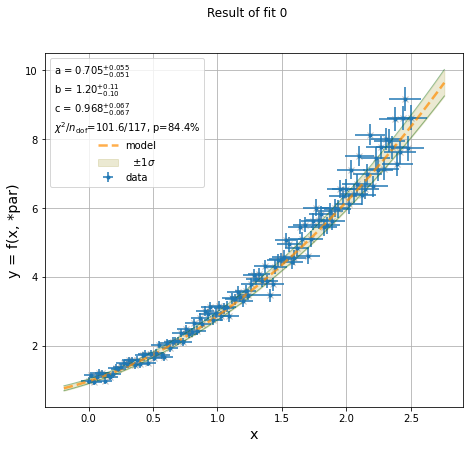

In [15]:
# run MC loop
MC_loop()
print('\n\n*==* sucessfully analyzed {:d} data sets'.format(Nexp-nfail))  

In [16]:
def print_result():
  global nfail, biases, c2prb, N_coverage
    
  # - convert output to numpy arrays
  for i in range(npar):
    biases[i] = np.array(biases[i])
  c2prb = np.array(c2prb)

  ## plt.show() # blocks at this stage until figure deleted
  # results as printout
  N_succ = Nexp - nfail 
  print('\n\n*==* ', N_succ, ' successful fits done:')
  print(' * parameter names:')
  for i in range(npar):
    print('   {:d}: {:s}'.format(i, pnams[i])) 

  print(' * biases:')
  for i in range(npar):
  #  bias = deviation of parameters from their true values
    b = biases[i].mean()
    e = biases[i].std()/np.sqrt(Nexp)
    print('   {:d}: {:.3g} +\- {:.2g}'.format(i, b, e)) 

  print(' * coverage:')
  for i in range(npar):
  #  coverage: fraction of true val in confidence interval
    p_coverage = N_coverage[i]/(N_succ)*100//0.682689492
    print('   {:d}: {:.3g}%'.format(i, p_coverage))

print_result()



*==*  200  successful fits done:
 * parameter names:
   0: tau
   1: fbg
   2: a
 * biases:
   0: -0.00545 +\- 0.004
   1: -5.6e-05 +\- 0.0078
   2: 0.00762 +\- 0.0042
 * coverage:
   0: 90%
   1: 95%
   2: 104%


In diesem Beispeil gibt es keine signifikanten Verzerrungen, und die Überdeckung liegt
in der Nähe des für ein $\pm 1\sigma$-Intervall erwarteten Werts, d.h. 100% von 68.3%.

#### Grafische Darstellung der Ergebnisse

Eine einfache grafische Darstellung der Ergebnisse zeigt das Code-Fragment unten. 
Verwendung findet eine allgemeine Funktion zur Darstellung von Verteilungen und Korrelationen 
eines Datensatzes mit mehreren Variablen aus dem Paket *PhyPraKit*. 

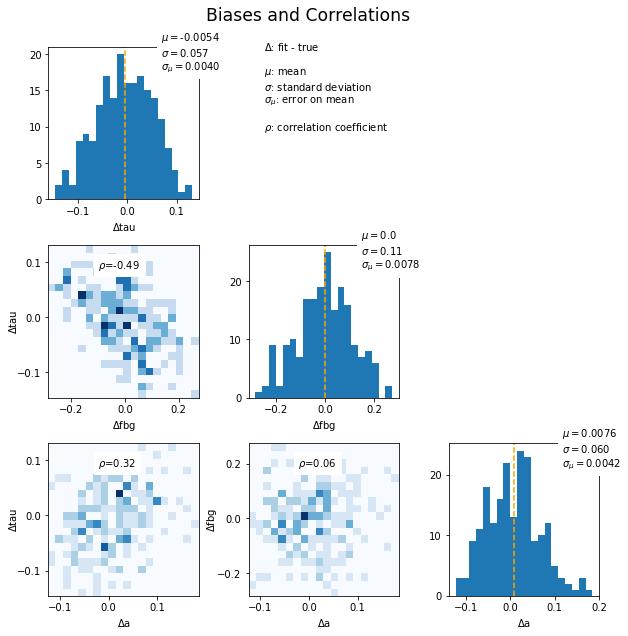

In [17]:
from PhyPraKit import plotCorrelations  

def plot_correlations():
  global nfail, biases, c2prb, N_coverage
  # plot results as array of sub-figures
  names = [r'$\Delta$'+pnams[i] for i in range(len(pnams))]
  fig, ax = plotCorrelations(biases, names)
  fig.suptitle("Biases and Correlations", size='xx-large')
  ax.text(0.1, 0.45,                
        '$\\Delta$: fit - true \n \n' +
        '$\\mu$: mean \n' +
        '$\\sigma$: standard deviation \n' +
        '$\\sigma_\\mu$: error on mean \n \n' +
        '$\\rho$: correlation coefficient',
         transform=ax.transAxes)
  plt.show()
  
plot_correlations()

Die beobachteten Verteilungen bestätigen die Schätzungen der Unsicherheiten und der Korrelationen durch die in *xyFit()* verwendeten Methoden. Wenn sich deutliche Unterschiede ergeben hätten, würde man die aus der Ensemble-Studie abgeleiteten Unsicherheiten und Korrelationen als Ergebnis angeben.

#### Verlässlichkeit des Hypothesentests

Als letzes Beispiel ist unten die Überprüfung der Qualität der als Hypothesentest eingesetzten
und aus dem in der Anpassung erhaltenen Wert von $\chi^2$ am Optimum und der Zahl der Freiheitsgrade
berechneten $\chi^2$-Wahrscheinlichkeit gezeigt. Diese sollte flach sein, wenn die Größe zur Bestimmung
der Goodness-of-Fit tatsächlich einer $\chi^2$-Verteilung folgt. 

compatibility of chi2 probability with flat distribution: 10.854834%


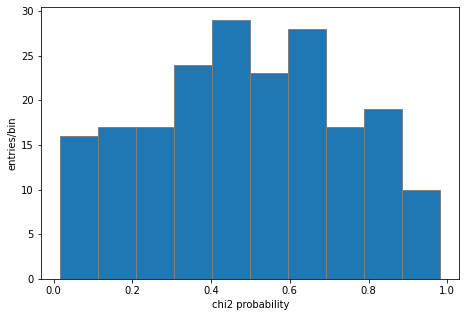

In [18]:
def analyse_chi2():
  global nfail, biases, c2prb, N_coverage
  # analysis of chi2 probability
  figc2prb = plt.figure(figsize=(7.5, 5.))
  ax = figc2prb.add_subplot(1,1,1)
  nbins= int(min(50, Nexp/20))
  binc, bine, _ = ax.hist(c2prb, bins=nbins, ec="grey")
  plt.xlabel('chi2 probability')
  plt.ylabel('entries/bin')
  # - check compatibility with flat distribution
  mean = (Nexp-nfail)/nbins
  chi2flat= np.sum( (binc - mean)**2 / mean )
  prb = 1.- stats.chi2.cdf(chi2flat, nbins)
  print('compatibility of chi2 probability with flat distribution: {:f}%'.format(prb*100))  

  plt.show()

analyse_chi2()

In diesem Fall ist die beobachtete Verteilung tatsächlich im Rahmen eines ebenfalls mit der
$\chi^2$-Methode durchgeführten Tests auf Übereinstimmung mit einer Rechteckverteilung flach. Allerdings zeigen sich bei Erhöhung der Zahl der untersuchten Stichproben statistisch
signifikante Abweichungen, die aber noch hinreichend klein sind, so dass man den Wert von
$\chi^2$ als Qualitätskriterium für die Anpassung verwenden kann. Mit Hilfe der nun
aus dem Ensemble-Test bekannten Verteilung könnte man auch die kritische Grenze für das 
Verwerfen der Modellhypothese entsprechend angepassen. 

Übrigens: der Hauptgrund für die Abweichung der $\chi^2$-Wahrscheinlichkeit von der 
Rechteckverteilung sind in diesem Beispiel die relativen, auf den Modellwert bezogenen
Unsicherheiten der Messdaten. Schaltet man diese in der Simulation und im Modell aus,
ergibt sich eine deutlich bessere Übereinstimmung mit der Rechteckverteilung. 

#### Überprüfung der Robustheit

Die Überprüfung der Robustheit einer Anpassung ist eines der schwierigsten Probleme. 
Auch hier helfen Ensemble-Tests, bei denen dann aber Stichproben der Daten erzeugt werden,
die anders aussehen als im Modell angenommen. So können Effekte von falsch abgeschätzten
Unsicherheiten, leicht variierten Modellfunktionen oder von seltenen Ausreißern in 
Verteilungen studiert werden. 

#### Studie 1: Behandlung relativer Unsicherheiten

Mit dem oben definierten Set-up sind nun leicht weitere Studien der Auswirkungen bestimmter 
Optionen der Anpassung leicht durchzuführen. Dazu müssen lediglich die entsprechenden Optionen
verändert und die Sequenz der oben durchgeführten Schritte wiederholt werden. 
Gezeigt ist das im Beispiel in der nächsten Zelle für den Fall, dass relative Unsicherheiten auf die 
Daten statt auf den Modellwert bezogen werden. 

generating data - patience please!

*==*  Fit 0 Result:
 chi2: 105.5
 parameter names:   ('a', 'b', 'c')
 parameter values:   [0.631066 1.076625 0.873969]
 parameter errors:  [[-0.052  0.055]
 [-0.103  0.106]
 [-0.068  0.068]]
 correlations : 
 [[ 1.    -0.391  0.433]
 [-0.391  1.     0.018]
 [ 0.433  0.018  1.   ]]

***************************************************************************************************

*==* sucessfully analyzed 200 data sets


*==*  200  successful fits done:
 * parameter names:
   0: tau
   1: fbg
   2: a
 * biases:
   0: -0.0958 +\- 0.0035
   1: -0.126 +\- 0.0068
   2: -0.11 +\- 0.0036
 * coverage:
   0: 30%
   1: 56%
   2: 26%


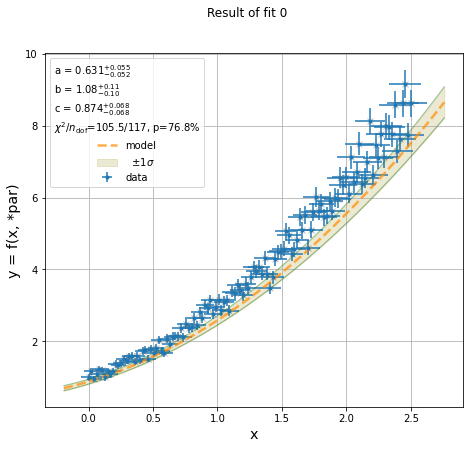

In [19]:
# modify fit optoins
kw_options = {  # options for Fit
            'ref_to_model': False,   # !!! rel. uncert. w.r.t to data
            'use_negLogL': True     # standard chi^2 if false
       }
# execute MC loop and analysis ...
MC_loop()
# ... and print results
print('\n\n*==* sucessfully analyzed {:d} data sets'.format(Nexp-nfail))  
print_result()

Wie der Output zeigt, sind die Parameter nun signifkant verzerrt, und die Überdeckung
ist sehr viel schechter geworden, d.h. die Angaben der Unsicherheiten sind in diesem 
Fall nicht zuverlässig.  Die grafische Darstellung der Ergebnisse des ersten Pseudodatensatzes
zeigt, was passiert: Datenpunkten, die zu kleineren Werten fluktuieren, werden kleinere 
relative Unsicherheiten zugewiesen, und dementsprechend größere Unsicherheiten für Datenpunkte,
die zu größeren Werten fluktuieren. Im Ergebnis wird die angepasste Modellfunktion dadurch hin zu
kleineren $y$-Werten gezogen.  Nicht in allen Fällen ist der Effekt so deutlich in der Ergebnisgrafik
sichtbar wie indiesem Fall! Den größten Beitrag zur offensichtlichen Abweichung des angepassten
Modells an die Daten liefert übrigens die relative, korrelierte Unsicherheit von 3% auf die $y$-Werte.

#### Studie 2: Vergleich mit der Methode der kleinsten Quadrate

Verwendet man anstelle der Likelihood-Methode die klassische $\chi^2$-Methode, so ergeben 
sich ebenfalls starke Verzerrungen und schlechte Werte für die Abdeckung des Konfidenzintervalls
der Parameter. 

generating data - patience please!

*==*  Fit 0 Result:
 chi2: 82.18
 parameter names:   ('a', 'b', 'c')
 parameter values:   [0.895477 1.437303 1.126419]
 parameter errors:  [[-0.081  0.09 ]
 [-0.137  0.144]
 [-0.081  0.085]]
 correlations : 
 [[ 1.    -0.365  0.386]
 [-0.365  1.     0.087]
 [ 0.386  0.087  1.   ]]

***************************************************************************************************

*==* sucessfully analyzed 200 data sets


*==*  200  successful fits done:
 * parameter names:
   0: tau
   1: fbg
   2: a
 * biases:
   0: 0.206 +\- 0.0053
   1: 0.229 +\- 0.0085
   2: 0.166 +\- 0.0048
 * coverage:
   0: 5%
   1: 30%
   2: 13%


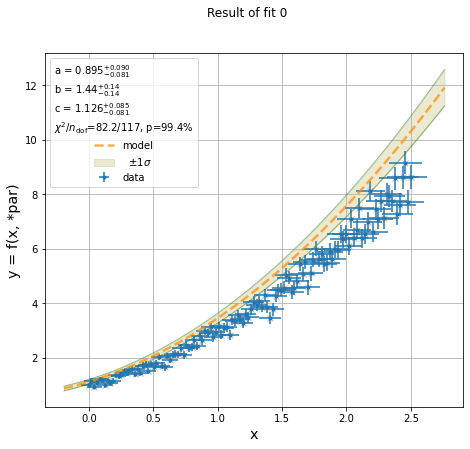

In [20]:
# modify fit optoins
kw_options = {  # options for Fit
            'ref_to_model': True,   # rel. uncert. w.r.t model
            'use_negLogL': False     # !!! use standard chi^2 
       }
# execute MC loop and analysis ...
MC_loop()
print('\n\n*==* sucessfully analyzed {:d} data sets'.format(Nexp-nfail))  
# ... and print results
print_result()

In diesem Fall wird die angepasst Modellfuktion hin zu größeren $y$-Werten gezogen. Der Grund
ist die Vernachlässigung der parameterabhängigen Unsicherheiten in der Kostenfunkton. 
Wenn die Modellfunktion größere Werte vorhersagt, werden auch die relativen Unsicherheiten 
entsprechend größer und damit der $\chi^2$-Wert entsprechend kleiner. Der Term $\ln(\det(V))$ 
in der vollen log-Likelihood wirkt diesem Effekt entgegen. Wieder ist in vielen Fällen das Problem
nicht so klar sichtbar wie in diesem Beispeil mit recht großen Anteilen relativer Unsicherheiten.
Der Test "mit dem Auge", d.h. scheinbar gute Übereinstimmung von Datenpunkten und Modell, 
täuscht oft.

Im Ergebnis ist festzuhalten, dass unbedingt die Optionen             
```
ref_to_model=True,     # rel. uncert. w.r.t model
use_negLogL': True     # use standard n2lL cost function
```
verwendet werden sollten. In *kafe* und *PhyPraKit.phyFit* ist das korrekte Verhalten
voreingestellt. Bei Verwendung anderer Anpassungsprogramme ist Vorsicht geboten,
wenn relative Unsicherheiten im Spiel sind. 

***
# Abschließende Anmerkungen

Mit den in diesem Tutorial beschriebenen Verfahren zur Anpassung von Modellen an Messdaten
sind Sie für Anwendungen in den Fortgeschrittenenpraktika oder in Ihren Abschlussarbeiten
bestens gerüstet. Die beschriebenen Methoden entsprechen den in der Wissenschaft üblichen,
und Sie werden in wissenschaftlichen Veröffentlichungen einigen davon wieder begegnen. 

Die hier gezeigten Beispiele basieren mit Absicht auf dem schlanken Anpassungswerkzeug 
*phyFit*, um die Transparenz der Vorgehensweise sicher zu stellen und Ihnen durch 
Modifikation der Beispiele eigene Studien und Anpassungen an spezielle Problemstellungen
zu ermöglichen. Da *phyFit* nur eine schlanke Interface-Ebene darstellt und im Übrigen auf dem 
im wissenschaftlichen Umfeld seit langem etablierten und anerkannten Paket MINUIT zur Optimierung
in hochdimensionalen Parameterräumen und zur Schätzung der  Parameterunsicherheiten basiert, sind 
Ihre damit erzielten Ergebnisse fachlich sehr gut abgesichert und in eigenen Arbeiten "zitierfähig".


***
***